<a href="https://colab.research.google.com/github/chi-hun/kaggle/blob/main/Natural_Language_Processing_with_Disaster_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Natural Language Processing with Disaster Tweets  https://www.kaggle.com/competitions/nlp-getting-started/overview

# module

In [1]:
import pandas as pd
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt
import nltk
import re
import tensorflow as tf
from tensorflow.keras import layers
import gensim
!pip install pyspellchecker
from spellchecker import SpellChecker

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.7 MB 3.2 MB/s 


# data load

In [3]:
!install kaggle
!mkdir -p ~/.kaggle
files.upload()
!cp kaggle.json ~/.kaggle/
!chmod -600 ~/.kaggle/kaggle.json

install: missing destination file operand after 'kaggle'
Try 'install --help' for more information.


In [4]:
!kaggle competitions download -c nlp-getting-started

  0% 0.00/593k [00:00<?, ?B/s]
100% 593k/593k [00:00<00:00, 80.1MB/s]


In [5]:
!unzip /content/nlp-getting-started.zip

Archive:  /content/nlp-getting-started.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [6]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

# EDA

## 1, info

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [8]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [9]:
train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [10]:
train.id.value_counts()

1        1
7229     1
7250     1
7248     1
7247     1
        ..
3638     1
3637     1
3636     1
3635     1
10873    1
Name: id, Length: 7613, dtype: int64

In [11]:
train[(~train['keyword'].isna()) & (~train['location'].isna())]

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0
...,...,...,...,...,...
7575,10826,wrecked,TN,On the bright side I wrecked http://t.co/uEa0t...,0
7577,10829,wrecked,#NewcastleuponTyne #UK,@widda16 ... He's gone. You can relax. I thoug...,0
7579,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0
7580,10832,wrecked,London,#FX #forex #trading Cramer: Iger's 3 words tha...,0


In [12]:
pd.set_option('display.max_rows', 300)
train['keyword'].value_counts()

fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
harm                     41
body%20bags              41
outbreak                 40
evacuate                 40
fear                     40
collided                 40
siren                    40
twister                  40
windstorm                40
sinkhole                 39
sunk                     39
hellfire                 39
weapon                   39
weapons                  39
famine                   39
explosion                39
whirlwind                39
earthquake               39
derailment               39
wreckage                 39
collision                39
flames                   39
wrecked                  39
oil%20spill              38
flooding                 38
deaths                   38
derailed                 38
thunder                  38
ambulance                38
drowned                  38
explode             

In [13]:
train.iloc[100,:]

id                                                        144
keyword                                              accident
location                                                   UK
text        .@NorwayMFA #Bahrain police had previously die...
target                                                      1
Name: 100, dtype: object

In [14]:
train.iloc[100,:]['text']

'.@NorwayMFA #Bahrain police had previously died in a road accident they were not killed by explosion https://t.co/gFJfgTodad'

In [15]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


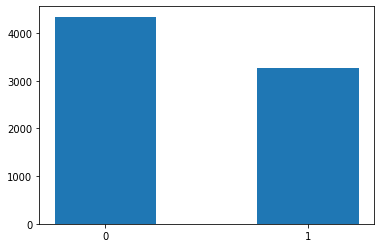

In [16]:
a = train['target'].value_counts().to_frame().T
plt.bar(a.columns, a.values[0], width=0.5)
plt.xticks([0,1])
plt.show()

## 2, sub, tokenizer, stopword

In [17]:
nltk.download('punkt')
nltk.download('stopwords')
def to_token(x):
    x = re.sub('\W', ' ', x)
    x = nltk.tokenize.word_tokenize(x.lower())
    stop_word = set(nltk.corpus.stopwords.words('english'))
    x = [i for i in x if i not in stop_word]
    return x
train['text'] = train['text'].apply(to_token)
test['text'] = test['text'].apply(to_token)
train.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,id,keyword,location,text,target
0,1,NaN,NaN,"[deeds, reason, earthquake, may, allah, forgiv...",1
1,4,NaN,NaN,"[forest, fire, near, la, ronge, sask, canada]",1
2,5,NaN,NaN,"[residents, asked, shelter, place, notified, o...",1
3,6,NaN,NaN,"[13, 000, people, receive, wildfires, evacuati...",1
4,7,NaN,NaN,"[got, sent, photo, ruby, alaska, smoke, wildfi...",1


## 3, keyword + text(location drop)

In [18]:
train['keyword'] = train['keyword'].str.split('%20')
test['keyword'] = test['keyword'].str.split('%20')
train[~train['keyword'].isna()].head()

,id,keyword,location,text,target
31,48,[ablaze],Birmingham,"[bbcmtd, wholesale, markets, ablaze, http, co,...",1
32,49,[ablaze],Est. September 2012 - Bristol,"[always, try, bring, heavy, metal, rt, http, c...",0
33,50,[ablaze],AFRICA,"[africanbaze, breaking, news, nigeria, flag, s...",1
34,52,[ablaze],"Philadelphia, PA","[crying, set, ablaze]",0
35,53,[ablaze],"London, UK","[plus, side, look, sky, last, night, ablaze, h...",0


In [19]:
key_index = train[~train['keyword'].isna()].index
key_index_t = test[~test['keyword'].isna()].index
key_index

Int64Index([  31,   32,   33,   34,   35,   36,   37,   38,   39,   40,
            ...
            7573, 7574, 7575, 7576, 7577, 7578, 7579, 7580, 7581, 7582],
           dtype='int64', length=7552)

In [20]:
train.loc[train.index.isin(key_index), 'text'] = train['text'] + train['keyword']
test.loc[test.index.isin(key_index_t), 'text'] = test['text'] + test['keyword']
train.loc[key_index]

,id,keyword,location,text,target
31,48,[ablaze],Birmingham,"[bbcmtd, wholesale, markets, ablaze, http, co,...",1
32,49,[ablaze],Est. September 2012 - Bristol,"[always, try, bring, heavy, metal, rt, http, c...",0
33,50,[ablaze],AFRICA,"[africanbaze, breaking, news, nigeria, flag, s...",1
34,52,[ablaze],"Philadelphia, PA","[crying, set, ablaze, ablaze]",0
35,53,[ablaze],"London, UK","[plus, side, look, sky, last, night, ablaze, h...",0
...,...,...,...,...,...
7578,10830,[wrecked],NaN,"[jt_ruff23, cameronhacker, wrecked, wrecked]",0
7579,10831,[wrecked],"Vancouver, Canada","[three, days, work, pretty, much, wrecked, hah...",0
7580,10832,[wrecked],London,"[fx, forex, trading, cramer, iger, 3, words, w...",0
7581,10833,[wrecked],Lincoln,"[engineshed, great, atmosphere, british, lion,...",0


## 4, SpellChecker

In [21]:
spell = SpellChecker()
def spell_re(x):
    re = []
    miss = spell.unknown(x)
    for word in x:
        if word in miss:
            re.append(spell.correction(word))
        else :
            re.append(word)
    return re
train['text'] = train['text'].apply(spell_re)
test['text'] = test['text'].apply(spell_re)
train.head(2)

,id,keyword,location,text,target
0,1,NaN,NaN,"[deeds, reason, earthquake, may, allah, forgiv...",1
1,4,NaN,NaN,"[forest, fire, near, la, range, ask, canada]",1


## 5, tf labeling

In [22]:
est['text'])
train.head(3)

,id,keyword,location,text,target
0,1,NaN,NaN,"[4397, 729, 86, 88, 1392, 4398, 41]",1
1,4,NaN,NaN,"[46, 5, 326, 602, 2335, 935, 1113]",1
2,5,NaN,NaN,"[1639, 1514, 1818, 603, 6529, 1640, 97, 1818, ...",1


In [23]:
index_word = tokenizer.index_word
index_word[0] = '<PAD>'
word_types = len(index_word) + 1 
word_types

20065

## 6, padding

In [24]:
print(train['text'].str.len().min())
print(train['text'].str.len().quantile(0.9))
print(train['text'].str.len().max())

1
18.0
28


In [25]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(train['text'],maxlen=18)
x_test = tf.keras.preprocessing.sequence.pad_sequences(test['text'],maxlen=18)
y_train = train['target']
x_train










array([[    0,     0,     0, ...,  1392,  4398,    41],
       [    0,     0,     0, ...,  2335,   935,  1113],
       [    0,     0,     0, ...,   603,  1295,   992],
       ...,
       [    0,     0,     0, ...,     2,     1,  6497],
       [    0,    24,  1028, ...,    82,  1945,   156],
       [    0,     0,     0, ...,     2,     1, 20063]], dtype=int32)

## 7, word2vec

In [26]:
model_word2vec = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/MyDrive/Colab Notebooks/GoogleNews-vectors-negative300.bin.gz', binary =True)

In [27]:
model_word2vec.vectors.shape

(3000000, 300)

In [28]:
embadding_weight = np.zeros((word_types,300))
embadding_weight.shape

(20065, 300)

In [29]:
ct = 0
def get_vectors(x):
    global ct
    if x in model_word2vec:
        return model_word2vec[x]
    else:
        ct += 1
        return None

for x, i in tokenizer.word_index.items():
    temp = get_vectors(x)
    if temp is not None:
        embadding_weight[i] = temp
print(ct)

8833


# modeling

In [30]:
max_len = 18
input_dim = word_types
def model_make1():
    inputs = layers.Input(shape=max_len)
    x = layers.Embedding(input_dim = input_dim, output_dim = 300, input_length = max_len, weights = [embadding_weight], trainable = False)(inputs)
    x = layers.Bidirectional(layers.LSTM(256, return_sequences = True))(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [31]:
model = model_make1()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18)]              0         
                                                                 
 embedding (Embedding)       (None, 18, 300)           6019500   
                                                                 
 bidirectional (Bidirectiona  (None, 18, 512)          1140736   
 l)                                                              
                                                                 
 global_average_pooling1d (G  (None, 512)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 128)               65664 

In [32]:
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [33]:
his = model.fit(x_train, y_train, epochs=10, validation_split = 0.2)

Epoch 1/10
191/191 [==============================] - 44s 206ms/step - loss: 0.4768 - accuracy: 0.7892 - val_loss: 0.4447 - val_accuracy: 0.7932
Epoch 2/10
191/191 [==============================] - 36s 190ms/step - loss: 0.4267 - accuracy: 0.8141 - val_loss: 0.4395 - val_accuracy: 0.8024
Epoch 3/10
191/191 [==============================] - 37s 194ms/step - loss: 0.4018 - accuracy: 0.8271 - val_loss: 0.4576 - val_accuracy: 0.7951
Epoch 4/10
191/191 [==============================] - 38s 198ms/step - loss: 0.3839 - accuracy: 0.8374 - val_loss: 0.4321 - val_accuracy: 0.8070
Epoch 5/10
191/191 [==============================] - 35s 184ms/step - loss: 0.3690 - accuracy: 0.8386 - val_loss: 0.4876 - val_accuracy: 0.7978
Epoch 6/10
191/191 [==============================] - 36s 190ms/step - loss: 0.3475 - accuracy: 0.8509 - val_loss: 0.4451 - val_accuracy: 0.8043
Epoch 7/10
191/191 [==============================] - 36s 186ms/step - loss: 0.3345 - accuracy: 0.8598 - val_loss: 0.4577 - val_ac

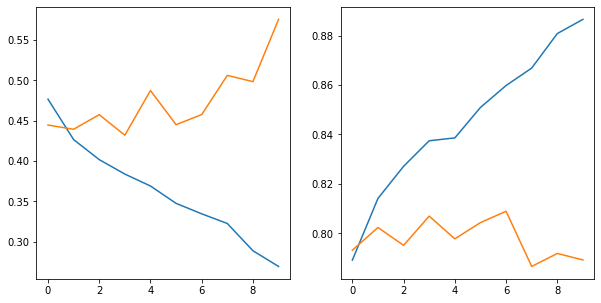

In [34]:
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.subplot(1,2,2)
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])
plt.show()

In [35]:
pre = model.predict(x_test)

In [36]:
pre = np.where(pre > 0.5, 1, 0)

In [37]:
sub = pd.read_csv('/content/sample_submission.csv')

In [38]:
sub['target'] = pre
sub.to_csv('submission.csv', index=False)